# Praparing work

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

# Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# q3 = -q2 + q8
# q9 = -q8 + q2

## DH definition in the order of joint_type, a, alpha, d, theta, dh_type, prev, succ

In [4]:
robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])

[q1, q2, q3]


In [5]:
robot_def.m

[0, m1, m2, m3]

## Create kinematics chain

In [11]:
geom = Geometry(robot_def)


pos_c1
v_cw1
dR_t1
subs dq1
w_b
pos_c2
v_cw2


dR_t2
subs dq2
w_b
pos_c3
v_cw3


dR_t3
subs dq3
w_b


pos_c
[0, Matrix([
[l1x*cos(q1)/m1 - l1y*sin(q1)/m1],
[l1x*sin(q1)/m1 + l1y*cos(q1)/m1],
[               l1z/m1 - 0.21537]]), Matrix([
[-l2x*sin(q2)*cos(q1)/m2 - l2y*cos(q1)*cos(q2)/m2 - l2z*sin(q1)/m2],
[-l2x*sin(q1)*sin(q2)/m2 - l2y*sin(q1)*cos(q2)/m2 + l2z*cos(q1)/m2],
[                       -l2x*cos(q2)/m2 + l2y*sin(q2)/m2 - 0.21537]]), Matrix([
[l3x*(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3))/m3 + l3y*(sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))/m3 - l3z*sin(q1)/m3 - 0.279*sin(q2)*cos(q1)],
[l3x*(sin(q1)*sin(q2)*sin(q3) - sin(q1)*cos(q2)*cos(q3))/m3 + l3y*(sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2))/m3 + l3z*cos(q1)/m3 - 0.279*sin(q1)*sin(q2)],
[                                              l3x*(sin(q2)*cos(q3) + sin(q3)*cos(q2))/m3 + l3y*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))/m3 - 0.279*cos(q2) - 0.21537]])]
v_cw
[0, Matrix([
[-dq1*(l1x*sin(q1) + l1y*cos(q1))/m1],
[ dq1*(l1x*cos(q1) - l1y*sin(q1))/m1],
[                                  0]]), Matrix([
[ (dq1*

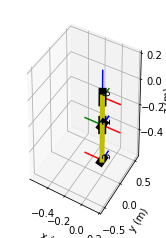

In [12]:
geom.draw_geom()

## Create dynamics object


In [13]:
dyn = Dynamics(robot_def, geom)


('k_e:', L1zz*dq1**2/2)


('k_e:', L2xx*dq1**2*cos(2*q2)/4 + L2xx*dq1**2/4 - L2xy*dq1**2*sin(2*q2)/2 - L2xz*dq1*dq2*cos(q2) - L2yy*dq1**2*cos(2*q2)/4 + L2yy*dq1**2/4 + L2yz*dq1*dq2*sin(q2) + L2zz*dq2**2/2)


('k_e:', -0.25*L3xx*dq1**2*cos(2*q2 + 2*q3) + 0.25*L3xx*dq1**2 + 0.5*L3xy*dq1**2*sin(2*q2 + 2*q3) + 1.0*L3xz*dq1*dq2*sin(q2 + q3) + 1.0*L3xz*dq1*dq3*sin(q2 + q3) + 0.25*L3yy*dq1**2*cos(2*q2 + 2*q3) + 0.25*L3yy*dq1**2 + 1.0*L3yz*dq1*dq2*cos(q2 + q3) + 1.0*L3yz*dq1*dq3*cos(q2 + q3) + 0.5*L3zz*dq2**2 + 1.0*L3zz*dq2*dq3 + 0.5*L3zz*dq3**2 - 0.1395*dq1**2*l3x*sin(q3) + 0.1395*dq1**2*l3x*sin(2*q2 + q3) - 0.1395*dq1**2*l3y*cos(q3) + 0.1395*dq1**2*l3y*cos(2*q2 + q3) - 0.01946025*dq1**2*m3*cos(2*q2) + 0.01946025*dq1**2*m3 + 0.279*dq1*dq2*l3z*cos(q2) - 0.279*dq2**2*l3x*sin(q3) - 0.279*dq2**2*l3y*cos(q3) + 0.0389205*dq2**2*m3 - 0.279*dq2*dq3*l3x*sin(q3) - 0.279*dq2*dq3*l3y*cos(q3))
3
dk_ddq_dtt:
L1zz*Derivative(q1t(t), t, t) - L2xx*sin(2*q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) + L2xx*cos(2*q2t(t))*Derivative(q1t(t), t, t)/2 + L2xx*Derivative(q1t(t), t, t)/2 - L2xy*sin(2*q2t(t))*Derivative(q1t(t), t, t) - 2*L2xy*cos(2*q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) + L2xz*sin(q2t(t)

dk_ddq_dt:
L1zz*ddq1 + L2xx*ddq1*cos(2*q2)/2 + L2xx*ddq1/2 - L2xx*dq1*dq2*sin(2*q2) - L2xy*ddq1*sin(2*q2) - 2*L2xy*dq1*dq2*cos(2*q2) - L2xz*ddq2*cos(q2) + L2xz*dq2**2*sin(q2) - L2yy*ddq1*cos(2*q2)/2 + L2yy*ddq1/2 + L2yy*dq1*dq2*sin(2*q2) + L2yz*ddq2*sin(q2) + L2yz*dq2**2*cos(q2) - 0.5*L3xx*ddq1*cos(2*q2 + 2*q3) + 0.5*L3xx*ddq1 + 0.5*L3xx*dq1*(2*dq2 + 2*dq3)*sin(2*q2 + 2*q3) + 1.0*L3xy*ddq1*sin(2*q2 + 2*q3) + 1.0*L3xy*dq1*(2*dq2 + 2*dq3)*cos(2*q2 + 2*q3) + 1.0*L3xz*ddq2*sin(q2 + q3) + 1.0*L3xz*ddq3*sin(q2 + q3) + 1.0*L3xz*dq2*(dq2 + dq3)*cos(q2 + q3) + 1.0*L3xz*dq3*(dq2 + dq3)*cos(q2 + q3) + 0.5*L3yy*ddq1*cos(2*q2 + 2*q3) + 0.5*L3yy*ddq1 - 0.5*L3yy*dq1*(2*dq2 + 2*dq3)*sin(2*q2 + 2*q3) + 1.0*L3yz*ddq2*cos(q2 + q3) + 1.0*L3yz*ddq3*cos(q2 + q3) - 1.0*L3yz*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*L3yz*dq3*(dq2 + dq3)*sin(q2 + q3) - 0.279*ddq1*l3x*sin(q3) + 0.279*ddq1*l3x*sin(2*q2 + q3) - 0.279*ddq1*l3y*cos(q3) + 0.279*ddq1*l3y*cos(2*q2 + q3) - 0.0389205*ddq1*m3*cos(2*q2) + 0.0389205*ddq1*m3 + 0.2

dk_ddq_dtt:
L2xz*sin(q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) - L2xz*cos(q2t(t))*Derivative(q1t(t), t, t) + L2yz*sin(q2t(t))*Derivative(q1t(t), t, t) + L2yz*cos(q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) + L2zz*Derivative(q2t(t), t, t) + 1.0*L3xz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*cos(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3xz*sin(q2t(t) + q3t(t))*Derivative(q1t(t), t, t) - 1.0*L3yz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*sin(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3yz*cos(q2t(t) + q3t(t))*Derivative(q1t(t), t, t) + 1.0*L3zz*Derivative(q2t(t), t, t) + 1.0*L3zz*Derivative(q3t(t), t, t) - 0.558*l3x*sin(q3t(t))*Derivative(q2t(t), t, t) - 0.279*l3x*sin(q3t(t))*Derivative(q3t(t), t, t) - 0.558*l3x*cos(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) - 0.279*l3x*cos(q3t(t))*Derivative(q3t(t), t)**2 + 0.558*l3y*sin(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) + 0.279*l3y*sin(q3t(t))*Derivative(q3t(t), t)**2 - 0.558*l3y*cos(q3t(t)

dk_ddq_dtt:
1.0*L3xz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*cos(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3xz*sin(q2t(t) + q3t(t))*Derivative(q1t(t), t, t) - 1.0*L3yz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*sin(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3yz*cos(q2t(t) + q3t(t))*Derivative(q1t(t), t, t) + 1.0*L3zz*Derivative(q2t(t), t, t) + 1.0*L3zz*Derivative(q3t(t), t, t) - 0.279*l3x*sin(q3t(t))*Derivative(q2t(t), t, t) - 0.279*l3x*cos(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) + 0.279*l3y*sin(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) - 0.279*l3y*cos(q3t(t))*Derivative(q2t(t), t, t)
dk_ddq_dt:
1.0*L3xz*ddq1*sin(q2 + q3) + 1.0*L3xz*dq1*(dq2 + dq3)*cos(q2 + q3) + 1.0*L3yz*ddq1*cos(q2 + q3) - 1.0*L3yz*dq1*(dq2 + dq3)*sin(q2 + q3) + 1.0*L3zz*ddq2 + 1.0*L3zz*ddq3 - 0.279*ddq2*l3x*sin(q3) - 0.279*ddq2*l3y*cos(q3) - 0.279*dq2*dq3*l3x*cos(q3) + 0.279*dq2*dq3*l3y*sin(q3)
dL_dq:
0.5*L3xx*dq1**2*sin(2*q2 + 2*q3) + 1.0*L3xy*dq1**2*cos(2*q2 + 2*q3) + 1.0*

tau: 
[L1zz*ddq1 + L2xx*ddq1*cos(2*q2)/2 + L2xx*ddq1/2 - L2xx*dq1*dq2*sin(2*q2) - L2xy*ddq1*sin(2*q2) - 2*L2xy*dq1*dq2*cos(2*q2) - L2xz*ddq2*cos(q2) + L2xz*dq2**2*sin(q2) - L2yy*ddq1*cos(2*q2)/2 + L2yy*ddq1/2 + L2yy*dq1*dq2*sin(2*q2) + L2yz*ddq2*sin(q2) + L2yz*dq2**2*cos(q2) - 0.5*L3xx*ddq1*cos(2*q2 + 2*q3) + L3xx*ddq1/2 + L3xx*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + L3xy*ddq1*sin(2*q2 + 2*q3) + 2*L3xy*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3) + L3xz*ddq2*sin(q2 + q3) + L3xz*ddq3*sin(q2 + q3) + L3xz*dq2*(dq2 + dq3)*cos(q2 + q3) + L3xz*dq3*(dq2 + dq3)*cos(q2 + q3) + L3yy*ddq1*cos(2*q2 + 2*q3)/2 + L3yy*ddq1/2 - 1.0*L3yy*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + L3yz*ddq2*cos(q2 + q3) + L3yz*ddq3*cos(q2 + q3) - 1.0*L3yz*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*L3yz*dq3*(dq2 + dq3)*sin(q2 + q3) - 0.279*ddq1*l3x*sin(q3) + 0.279*ddq1*l3x*sin(2*q2 + q3) - 0.279*ddq1*l3y*cos(q3) + 0.279*ddq1*l3y*cos(2*q2 + q3) - 0.0389205*ddq1*m3*cos(2*q2) + 0.0389205*ddq1*m3 + 0.279*ddq2*l3z*cos(q2) + 0.077841*dq1*dq2*m3*sin(2*q2) - 0.

Matrix([[0, 0, 0, 0, 0, ddq1, 0, 0, 0, 0, 0, 0, 0, ddq1*cos(2*q2)/2 + ddq1/2 - dq1*dq2*sin(2*q2), -ddq1*sin(2*q2) - 2*dq1*dq2*cos(2*q2), -ddq2*cos(q2) + dq2**2*sin(q2), -ddq1*cos(2*q2)/2 + ddq1/2 + dq1*dq2*sin(2*q2), ddq2*sin(q2) + dq2**2*cos(q2), 0, 0, 0, 0, 0, 0, 0, 0, -0.5*ddq1*cos(2*q2 + 2*q3) + ddq1/2 + dq1*(dq2 + dq3)*sin(2*q2 + 2*q3), ddq1*sin(2*q2 + 2*q3) + 2*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3), ddq2*sin(q2 + q3) + ddq3*sin(q2 + q3) + dq2*(dq2 + dq3)*cos(q2 + q3) + dq3*(dq2 + dq3)*cos(q2 + q3), ddq1*cos(2*q2 + 2*q3)/2 + ddq1/2 - 1.0*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3), ddq2*cos(q2 + q3) + ddq3*cos(q2 + q3) - 1.0*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*dq3*(dq2 + dq3)*sin(q2 + q3), 0, -0.279*ddq1*sin(q3) + 0.279*ddq1*sin(2*q2 + q3) - 0.279*dq1*dq3*cos(q3) + 0.279*dq1*(2*dq2 + dq3)*cos(2*q2 + q3), -0.279*ddq1*cos(q3) + 0.279*ddq1*cos(2*q2 + q3) + 0.279*dq1*dq3*sin(q3) - 0.279*dq1*(2*dq2 + dq3)*sin(2*q2 + q3), 0.279*ddq2*cos(q2) - 0.279*dq2**2*sin(q2), -0.0389205*ddq1*cos(2*q2) + 0.0389205*d

Matrix([[0], [0], [0]])
('input_vars', (q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3))
<function <lambda> at 0x7fa0677d02a8>
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.53097528e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.53349678e-01 -2.49294257e-01 -2.00660650e-01
   9.97478507e-02  1.51989957e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.07353415e-01  4.29984375e-02
   7.19794110e-01 -5.42558865e-02 -2.37972798e-01  0.00000000e+00
   1.56605845e-03 -9.84986365e-02  5.59843214e-02  7.76447245e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.51904458e-02


C:
Matrix([[-L2xx*dq1*dq2*sin(2*q2) - 2*L2xy*dq1*dq2*cos(2*q2) + L2xz*dq2**2*sin(q2) + L2yy*dq1*dq2*sin(2*q2) + L2yz*dq2**2*cos(q2) + L3xx*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + 2*L3xy*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3) + L3xz*dq2*(dq2 + dq3)*cos(q2 + q3) + L3xz*dq3*(dq2 + dq3)*cos(q2 + q3) - 1.0*L3yy*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) - 1.0*L3yz*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*L3yz*dq3*(dq2 + dq3)*sin(q2 + q3) + 0.077841*dq1*dq2*m3*sin(2*q2) - 0.279*dq1*dq3*l3x*cos(q3) + 0.279*dq1*dq3*l3y*sin(q3) + 0.279*dq1*l3x*(2*dq2 + dq3)*cos(2*q2 + q3) - 0.279*dq1*l3y*(2*dq2 + dq3)*sin(2*q2 + q3) - 0.279*dq2**2*l3z*sin(q2)], [0.5*L2xx*dq1**2*sin(2*q2) + 1.0*L2xy*dq1**2*cos(2*q2) - 0.5*L2yy*dq1**2*sin(2*q2) - 0.5*L3xx*dq1**2*sin(2*q2 + 2*q3) - 1.0*L3xy*dq1**2*cos(2*q2 + 2*q3) + 0.5*L3yy*dq1**2*sin(2*q2 + 2*q3) - 0.279*dq1**2*l3x*cos(2*q2 + q3) + 0.279*dq1**2*l3y*sin(2*q2 + q3) - 0.0389205*dq1**2*m3*sin(2*q2) - 0.558*dq2*dq3*l3x*cos(q3) + 0.558*dq2*dq3*l3y*sin(q3) - 0.279*dq3**2*l3x*cos(q3) + 0.279*dq3

('error: ', Matrix([
[L1zz*ddq1 + L2xx*(ddq1*cos(2*q2) + ddq1 - 2*dq1*dq2*sin(2*q2))/2 - L2xy*(ddq1*sin(2*q2) + 2*dq1*dq2*cos(2*q2)) - L2xz*(ddq2*cos(q2) - dq2**2*sin(q2)) + L2yy*(-ddq1*cos(2*q2) + ddq1 + 2*dq1*dq2*sin(2*q2))/2 + L2yz*(ddq2*sin(q2) + dq2**2*cos(q2)) + L3xx*(-1.0*ddq1*cos(2*q2 + 2*q3) + ddq1 + 2*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3))/2 + L3xy*(ddq1*sin(2*q2 + 2*q3) + 2*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3)) + L3xz*(ddq2*sin(q2 + q3) + ddq3*sin(q2 + q3) + dq2*(dq2 + dq3)*cos(q2 + q3) + dq3*(dq2 + dq3)*cos(q2 + q3)) + L3yy*(ddq1*cos(2*q2 + 2*q3) + ddq1 - 2.0*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3))/2 + L3yz*(ddq2*cos(q2 + q3) + ddq3*cos(q2 + q3) - 1.0*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*dq3*(dq2 + dq3)*sin(q2 + q3)) - ddq1*(1.0*L1zz + 1.0*L2xx + 1.0*L3xx + 2.04793005898978e-17*l3z + 3.64941667516078e-17*m3) - 0.279*l3x*(ddq1*sin(q3) - ddq1*sin(2*q2 + q3) + dq1*dq3*cos(q3) - dq1*(2*dq2 + dq3)*cos(2*q2 + q3)) - 0.279*l3y*(ddq1*cos(q3) - ddq1*cos(2*q2 + q3) - dq1*dq3*sin(q3) + dq1*(2*dq2 + dq

# Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [17]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

('joint constraint number: ', 2)
('cartisian constraint number: ', 0)
('constraint number: ', 8)
fourier_q_base:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.59154943e+00
  -7.95774715e-01 -5.30516477e-01 -3.97887358e-01 -3.18309886e-01
  -2.65258238e-01]
 [ 1.00000000e+00  1.38712673e-01  1.38184829e-01  1.37307768e-01
   1.36085491e-01  1.34523571e-01  1.32629119e-01 -1.58549310e+00
  -7.83685109e-01 -5.12439566e-01 -3.73891814e-01 -2.88486729e-01
  -2.29720373e-01]
 [ 1.00000000e+00  2.76369658e-01  2.72170982e-01  2.65258238e-01
   2.55757064e-01  2.43839520e-01  2.29720373e-01 -1.56737022e+00
  -7.47783628e-01 -4.59440746e-01 -3.04799399e-01 -2.04605651e-01
  -1.32629119e-01]
 [ 1.00000000e+00  4.11923304e-01  3.97887358e-01  3.75131798e-01
   3.44580560e-01  3.07463740e-01  2.65258238e-01 -1.53731870e+00
  -6.89161119e-01 -3.75131798e-01 -1.98943679e-01 -8.23846608e-02
  -1.62423826e-17]
 [ 1.00000000e+00  

('fstr: ', array([2.84745831]))
('xstr: ', array([-0.0160787 ,  0.00533606, -0.76619337, -1.        ,  1.        ,
        1.        ,  1.        ,  0.50812543, -0.10200176,  0.94793083,
        0.9086355 , -1.        ,  0.5256041 ,  0.42597943,  0.5360582 ,
       -0.21981194,  0.50857936,  0.4713275 , -0.80412024, -1.        ,
        0.04166542, -0.5946086 , -0.18421155, -1.        , -0.82346341,
        1.        ,  1.44086394, -1.        , -0.81802725,  1.        ,
        0.58968033,  1.        ,  0.46369451,  1.        ,  0.10707228,
       -0.01282884, -0.81037368,  1.        , -1.        ]))
('inform: ', {'text': 'Iteration limit exceeded', 'value': 9})

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    9.9380
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name 

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


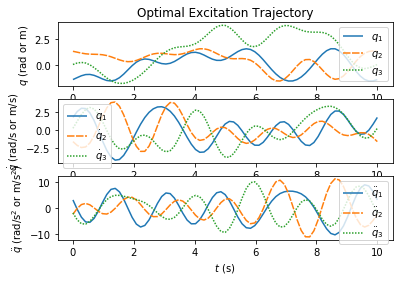

In [19]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [20]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [21]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

# Data processing

In [22]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [23]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [24]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


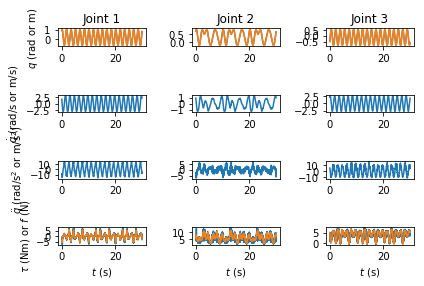

In [25]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [26]:
traj_optimizer.x_result

array([-0.0160787 ,  0.00533606, -0.76619337, -1.        ,  1.        ,
        1.        ,  1.        ,  0.50812543, -0.10200176,  0.94793083,
        0.9086355 , -1.        ,  0.5256041 ,  0.42597943,  0.5360582 ,
       -0.21981194,  0.50857936,  0.4713275 , -0.80412024, -1.        ,
        0.04166542, -0.5946086 , -0.18421155, -1.        , -0.82346341,
        1.        ,  1.44086394, -1.        , -0.81802725,  1.        ,
        0.58968033,  1.        ,  0.46369451,  1.        ,  0.10707228,
       -0.01282884, -0.81037368,  1.        , -1.        ])

# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [28]:
param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [29]:
print(W_b.shape, tau_s.shape)

((17970, 15), (17970,))


In [31]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [32]:
xb_ols

array([ 4.51759594e-01,  7.21406441e-02, -5.50129960e-04,  7.79418804e-04,
       -2.03789196e-02,  8.39004192e-01,  1.42708260e-02,  3.04222130e-03,
        1.04918787e-01, -9.80113090e-04,  1.30898057e-01,  1.21380433e-04,
        2.61028541e-01,  1.79097965e-01,  4.97529618e-02])

## Compare measured torque and predicted torque

### Generate predicted torque

In [33]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Plot measured torque and predicted torque

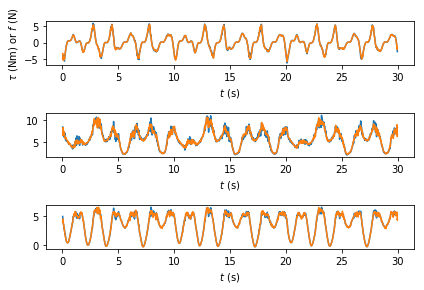

In [34]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization